**Import libraries**

In [1]:
import sys
import os
import random
import tensorflow
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from matplotlib.pyplot import figure

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

**Parsing the input dataset**

In [2]:
df=pd.read_csv("../nasdaq2007_17.csv", delimiter='\t', header=None)
df = df.T
rows_df = df.shape[1]

**Read number for forecast from the input**

In [3]:
print("Enter the desired number of time series to be predicted")
while True:
    try:
        n_predict=int(input())
    except ValueError:
        print("Enter valid integer number. Try again")
        continue
    if 1 <= n_predict <= rows_df:
        break
    else:
        print(f"Valid range: Enter 0 - {rows_df}")

Enter the desired number of time series to be predicted


 30


**Choose n random timeseries for forecast**

In [4]:
forecast_all_timeseries, forecast_each_timeseries = [], []
forecast_all_timeseries = random.sample(range(0, rows_df), n_predict)
#have pre-trained only the first 100 models
if n_predict > 100:
    n_predict = 100
forecast_each_timeseries = random.sample(range(0, 100), n_predict)

print(forecast_all_timeseries)
print(forecast_each_timeseries)

[216, 219, 315, 172, 86, 212, 54, 8, 168, 173, 75, 166, 307, 188, 33, 7, 291, 186, 62, 284, 155, 153, 259, 157, 89, 194, 46, 174, 332, 185]
[29, 0, 44, 49, 33, 20, 7, 30, 2, 26, 41, 48, 3, 4, 34, 18, 6, 11, 8, 25, 16, 35, 13, 1, 21, 43, 9, 23, 12, 47]


# First case: All timeseries

**Preprocessing dataset**

In [5]:
series = df.shape[1]
len_dataframe = len(df.index)
first_80_percent =  math.floor(len_dataframe * 80/100)
last_20_percent = len_dataframe - first_80_percent
training_set_list = []
testing_set_list = []
for i in range (0, series):
    temp_training_set = []
    temp_testing_set = []
    temp_training_set = df.iloc[1:first_80_percent, i].values #to idio me katw alla ana grammi
    temp_testing_set = df.iloc[first_80_percent:, i].values
    training_set_list.append(list(temp_training_set)) #etsi exoume kathe metoxi ksexwrista!
    testing_set_list.append(list(temp_testing_set))

training_set = df.iloc[1:first_80_percent, 0:df.shape[1]].values
test_set = df.iloc[first_80_percent:, 0:df.shape[1]].values

**Concatenate timeseries and scaling them**

In [6]:
X_train = []
y_train = []
sc = []
TIME_STEPS = 60

for k in range(0, series):

    # Feature Scaling
    sc.append(MinMaxScaler(feature_range = (0, 1)))
    temp=np.array(training_set_list[k])
    temp=temp.reshape(-1,1)
    training_set_scaled = sc[k].fit_transform(temp)
    
    # Creating a data structure with 60 time-steps and 1 output
    tmp_x = []
    tmp_y = []
    for i in range(TIME_STEPS, first_80_percent):
        tmp_x.append(training_set_scaled[i-TIME_STEPS:i, 0])
        tmp_y.append(training_set_scaled[i-1, 0])

    tmp_x, tmp_y = np.array(tmp_x), np.array(tmp_y)
    tmp_x = np.reshape(tmp_x, (tmp_x.shape[0], tmp_x.shape[1], 1))
    X_train.append(tmp_x)
    y_train.append(tmp_y)

**Reshape training set**

In [7]:
shape = first_80_percent - TIME_STEPS
X_train_new = np.array(X_train)
y_train_new = np.array(y_train)
y_train_new=y_train_new.reshape(series*shape)
X_train_new= X_train_new.reshape(series*shape, TIME_STEPS, 1)

**Build the LSTM model**

In [8]:
flag_saved_model = True;

if(flag_saved_model==True):

    # Recreate the exact same model, including its weights and the optimizer
    name = 'pre_trained_models/per_set_of_timeseries/model_A_all_timeseries.h5'
    model = tf.keras.models.load_model(name)

else:

    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train_new.shape[1], 1)))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))
    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.fit(X_train_new, y_train_new, epochs = 100, batch_size = 1024)
    name = 'model_A.h5'
    model.save(name)
    model_list.append(model)

**Prepare the test data and reshape them**

In [9]:
 X_test_list = []
 
 for k in forecast_all_timeseries:
    print(k)
    # Getting the predicted stock price
    dataset_train = df.iloc[1:first_80_percent, k]
    dataset_test = df.iloc[first_80_percent:, k]

    dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(dataset_test) - TIME_STEPS:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc[k].transform(inputs)

    X_test = []
    for i in range(TIME_STEPS, 791):
        X_test.append(inputs[i-TIME_STEPS:i, 0])
    X_test = np.array(X_test)
    X_test_list.append(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))

216
219
315
172
86
212
54
8
168
173
75
166
307
188
33
7
291
186
62
284
155
153
259
157
89
194
46
174
332
185


**Make Predictions using the test set**

In [10]:
predicted_stock_price = []
for k, val in enumerate(forecast_all_timeseries):
    predicted_stock_price.append(model.predict(X_test_list[k]))
    predicted_stock_price[k] = sc[val].inverse_transform(predicted_stock_price[k])

**Visualize the results**

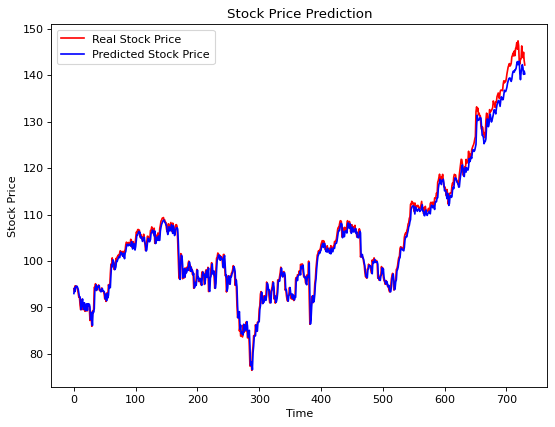

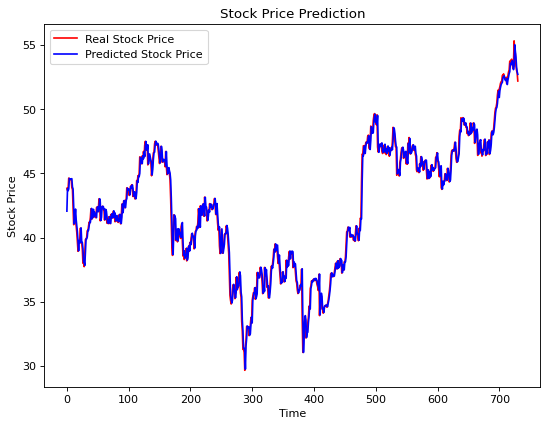

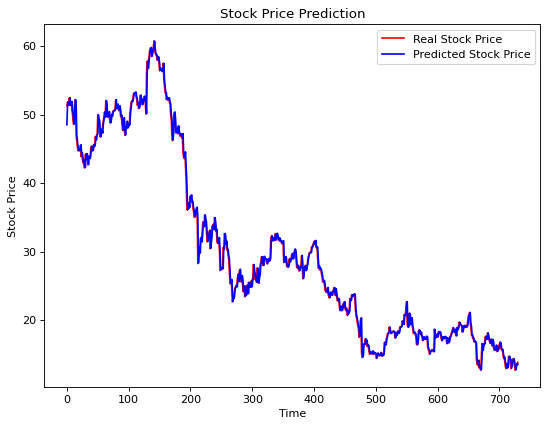

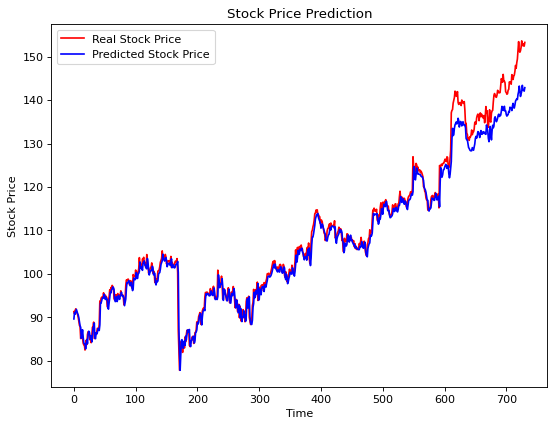

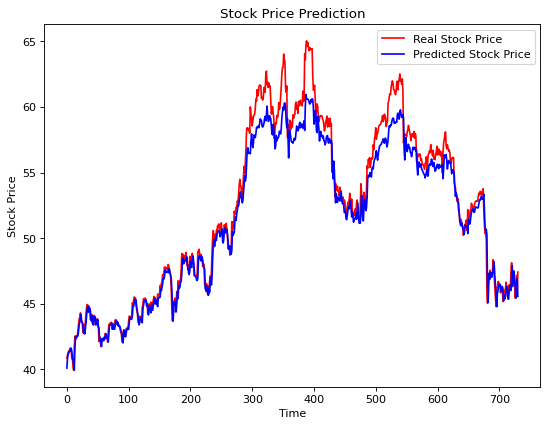

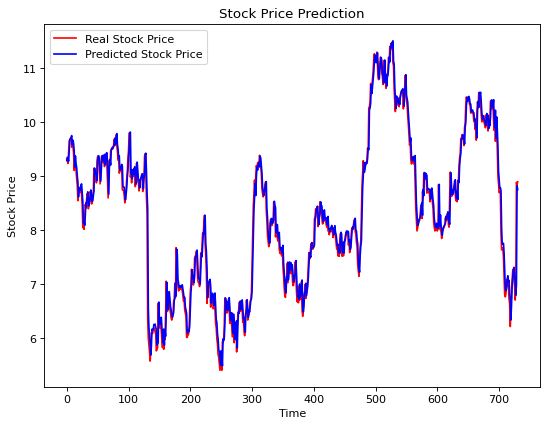

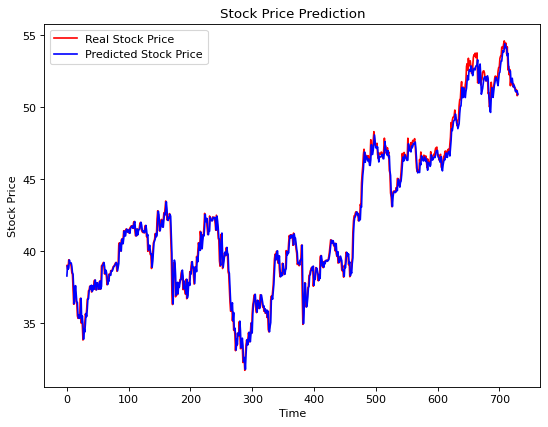

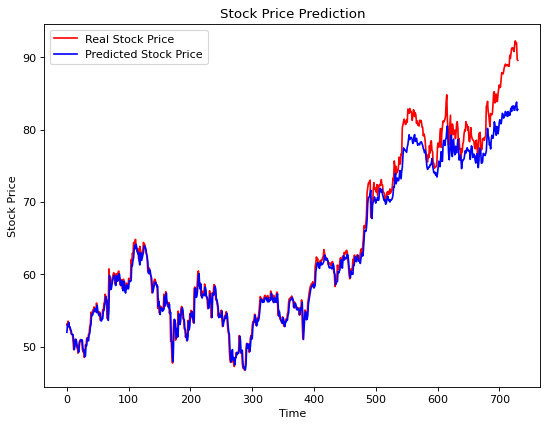

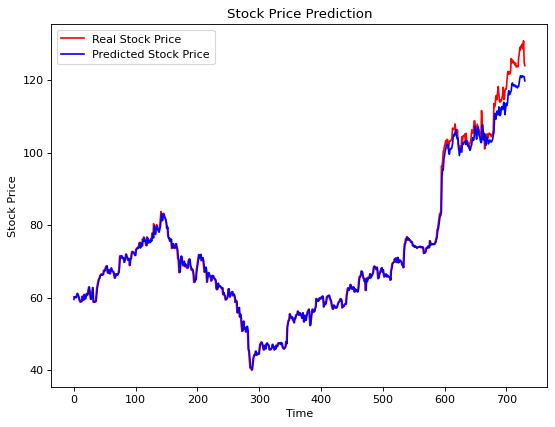

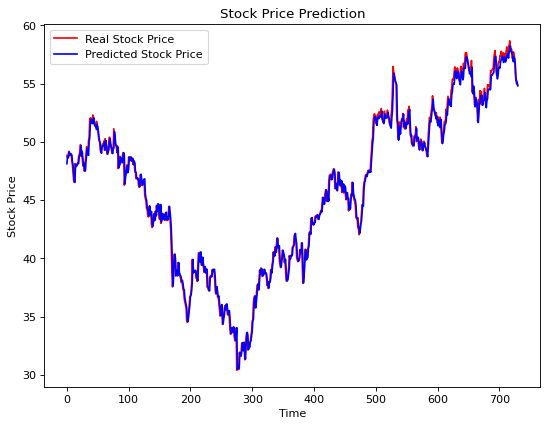

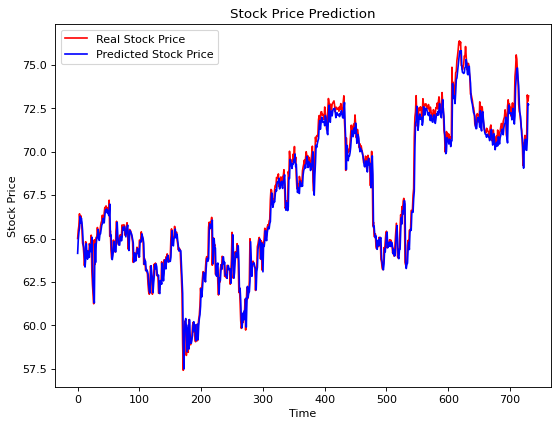

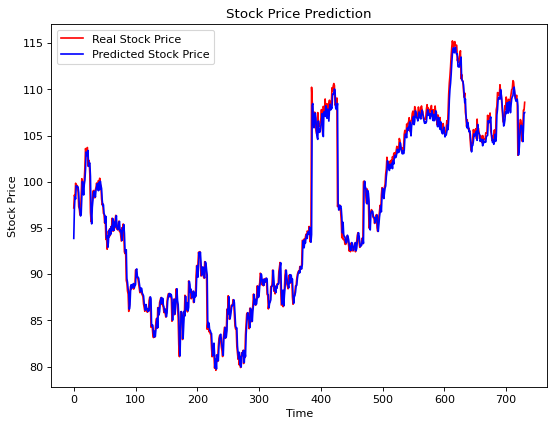

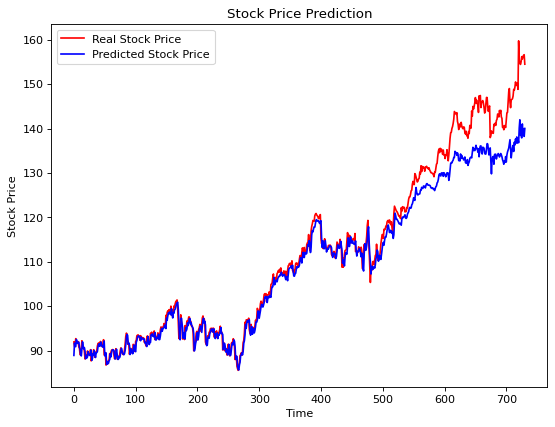

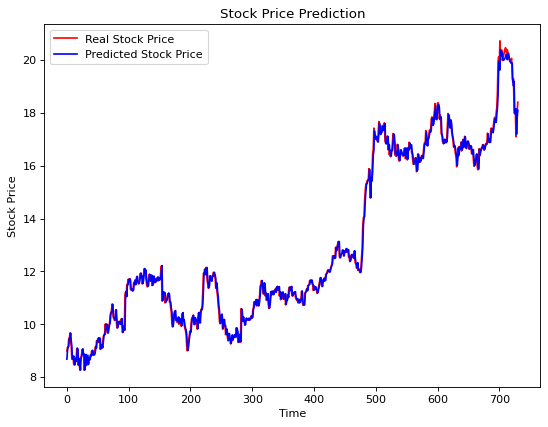

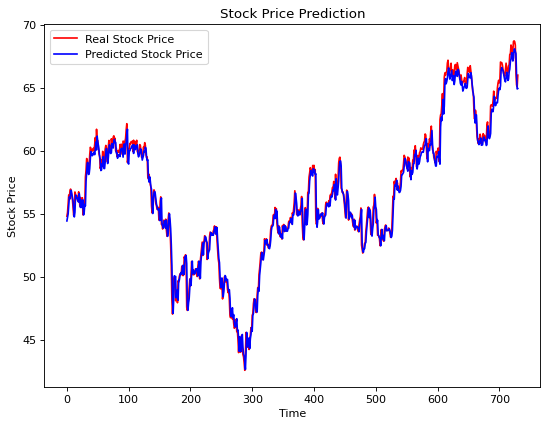

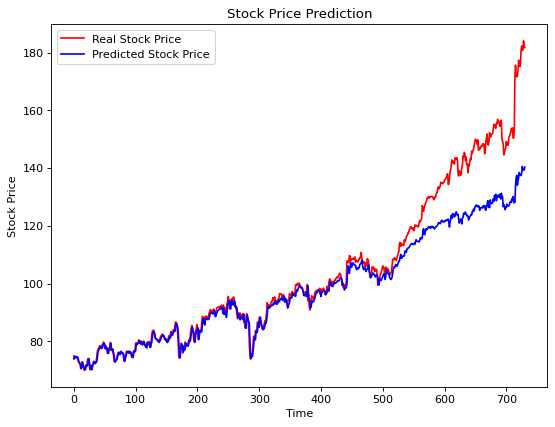

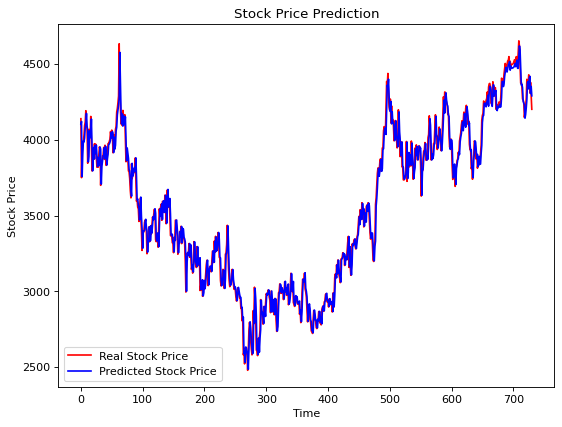

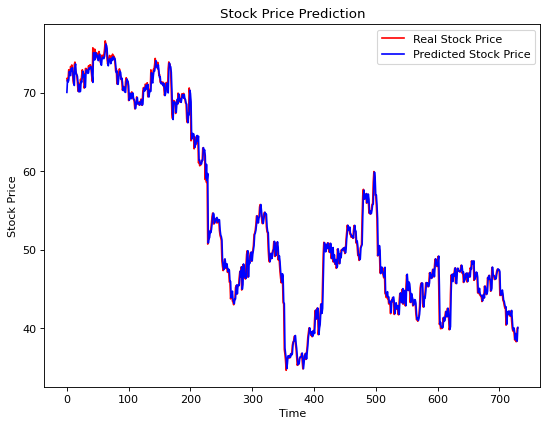

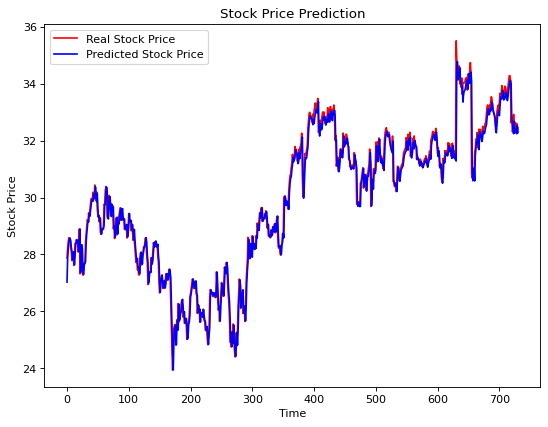

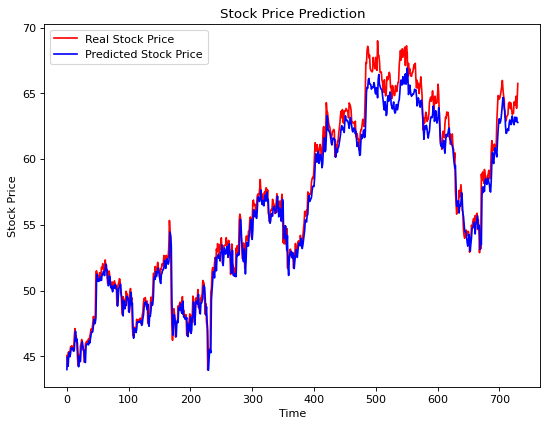

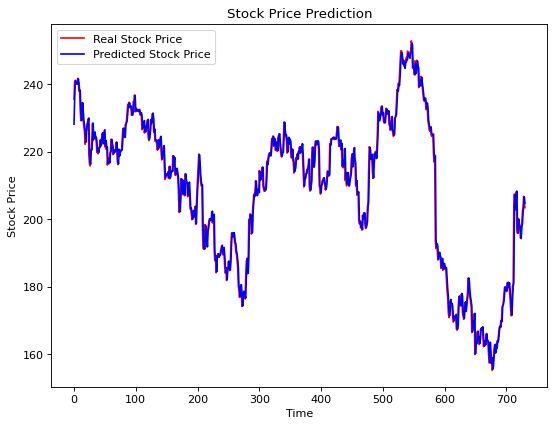

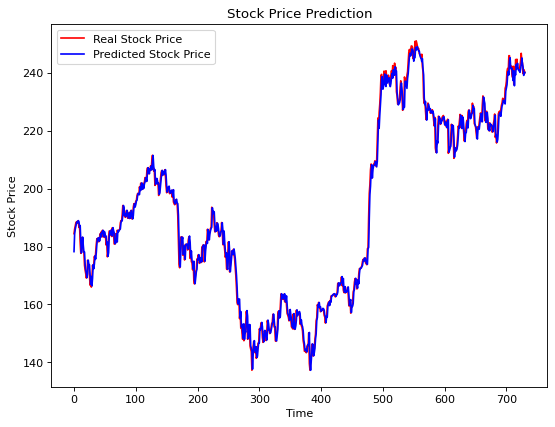

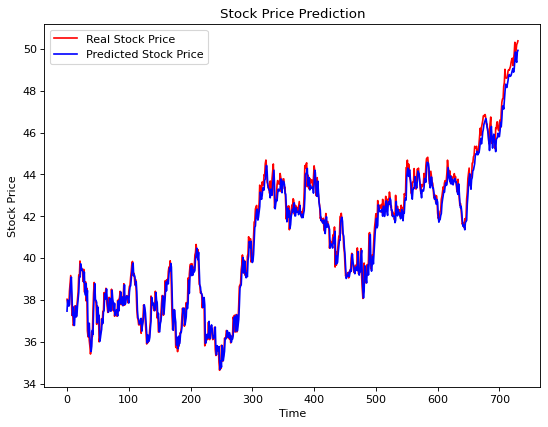

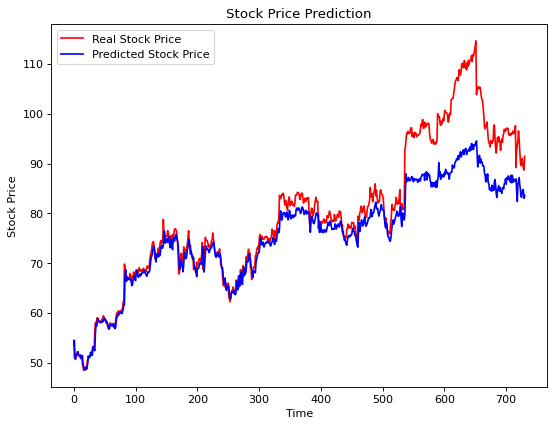

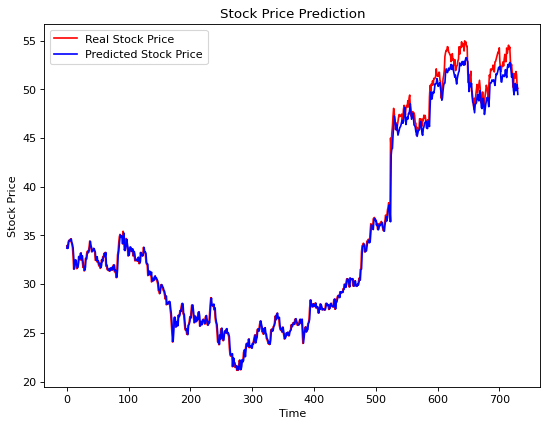

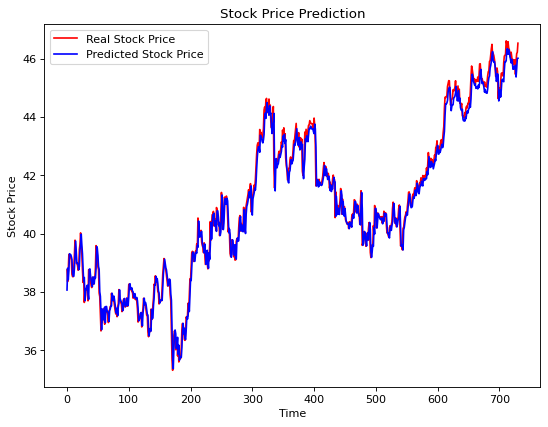

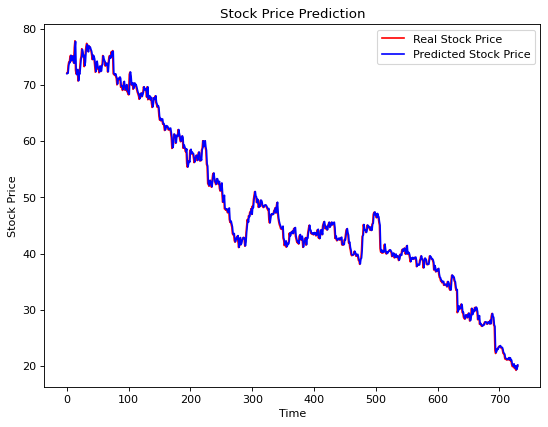

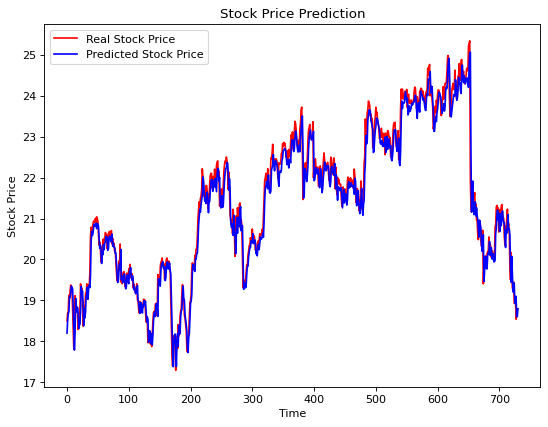

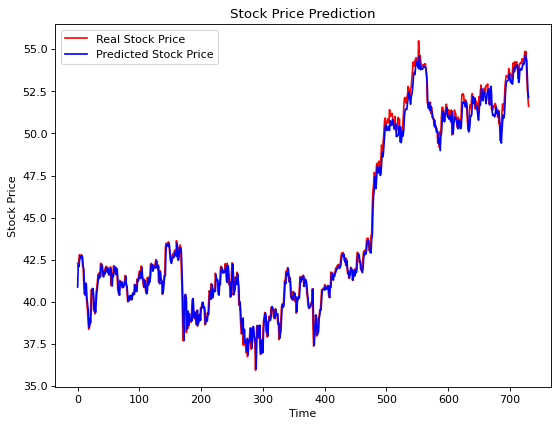

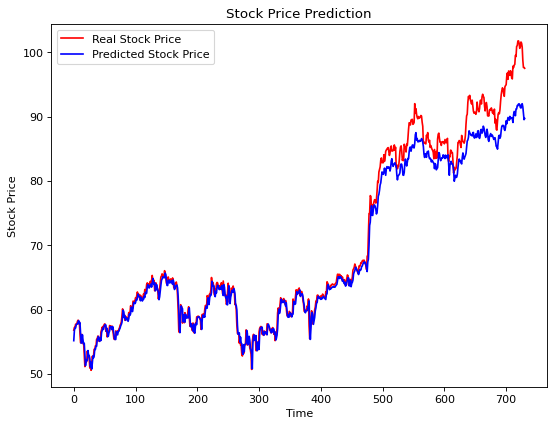

In [11]:
x = df[0].size-first_80_percent
for k, val in enumerate(forecast_all_timeseries):

    figure(figsize=(8, 6), dpi=80)
    dataset_test = df.iloc[first_80_percent:, val]

    plt.plot(range(0, x), dataset_test.values, color = 'red', label = 'Real Stock Price')
    plt.plot(range(0, x), predicted_stock_price[k], color = 'blue', label = 'Predicted Stock Price')
    plt.xticks(np.arange(0, 730, 100))
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Second case: One timeseries each time

**Scale and reshape training set**

In [12]:
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
sc = []
series=100
for k in range(0, series):

    sc.append(MinMaxScaler(feature_range = (0, 1)))
    tmp = df.iloc[1:first_80_percent, k:k+1].values
    # Feature Scaling
    training_set_scaled = sc[k].fit_transform(tmp)

    tmp_x = []
    tmp_y = []
    for i in range(TIME_STEPS, first_80_percent):
        tmp_x.append(training_set_scaled[i-TIME_STEPS:i, 0])
        tmp_y.append(training_set_scaled[i-1, 0])

    tmp_x, tmp_y = np.array(tmp_x), np.array(tmp_y)
    tmp_x = np.reshape(tmp_x, (tmp_x.shape[0], tmp_x.shape[1], 1))

    X_train.append(tmp_x)
    y_train.append(tmp_y)

**Build the LSTM model**

In [13]:
model_list = []
flag_saved_model = True

if(flag_saved_model==True):

    for val in forecast_each_timeseries:

        # Recreate the exact same model, including its weights and the optimizer
        name = 'pre_trained_models/per_timeseries/my_model_' + str(val+1) + '.h5'
        model = tf.keras.models.load_model(name)
        model_list.append(model)        
else:
    for k in range(0, n_predict):
        
        keras.backend.clear_session()
    
        model = Sequential()
        #Adding the first LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train[k].shape[1], 1)))
        model.add(Dropout(0.2))
        # Adding a second LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 64, return_sequences = True))
        model.add(Dropout(0.2))
        # Adding a third LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 64, return_sequences = True))
        model.add(Dropout(0.2))
        # Adding a fourth LSTM layer and some Dropout regularisation
        model.add(LSTM(units = 64))
        model.add(Dropout(0.2))
        # Adding the output layer
        model.add(Dense(units = 1))
        # Compiling the RNN
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        
        model.fit(X_train[k], y_train[k], epochs = 50, batch_size = 256, verbose=0)
        name = 'model_' + str(k+1) + '.h5'
        model.save(name)
        model_list.append(model)

**Prepare the test data and reshape them**

In [14]:
X_test_list = []

for k in forecast_each_timeseries:

    # Getting the predicted stock price
    dataset_train = df.iloc[1:first_80_percent, k]
    dataset_test = df.iloc[first_80_percent:, k]

    dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc[k].transform(inputs)

    X_test = []
    for i in range(TIME_STEPS, 791):
        X_test.append(inputs[i-TIME_STEPS:i, 0])
    X_test = np.array(X_test)
    X_test_list.append(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))

**Make Predictions using the test set**

In [15]:
predicted_stock_price = []
#We have pre-trained the first one hundred timeseries
if n_predict > 100:
    n_predict=100
for k, val in enumerate(forecast_each_timeseries):
    predicted_stock_price.append(model_list[k].predict(X_test_list[k]))
    predicted_stock_price[k] = sc[val].inverse_transform(predicted_stock_price[k])

**Visualize the results**

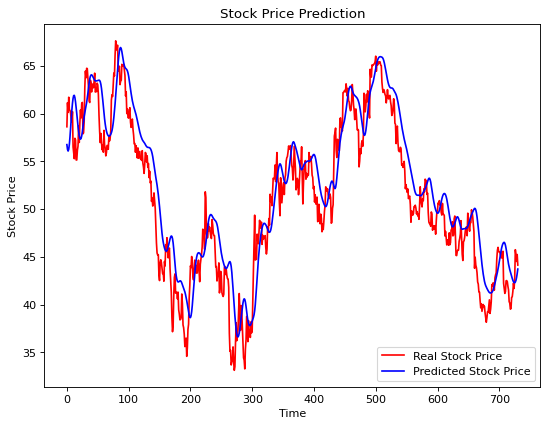

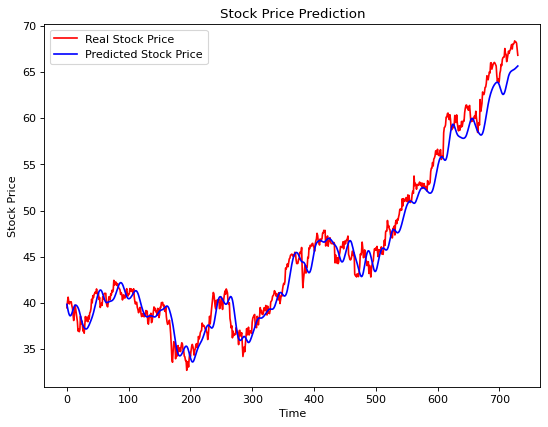

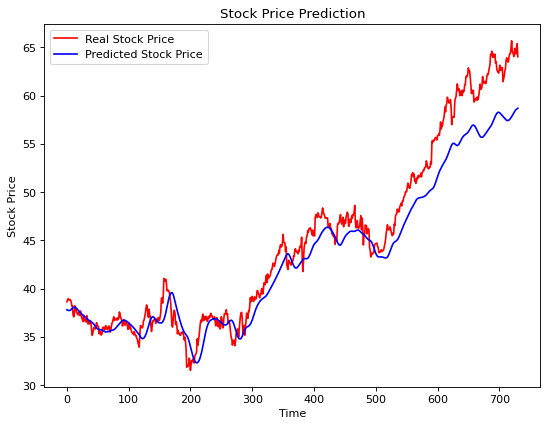

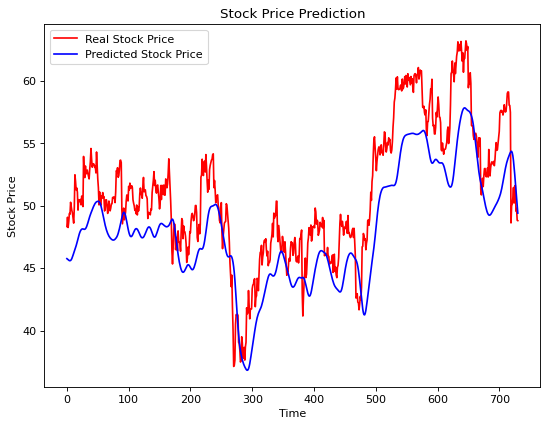

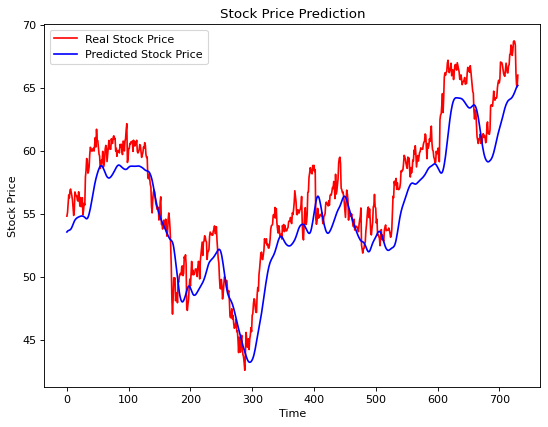

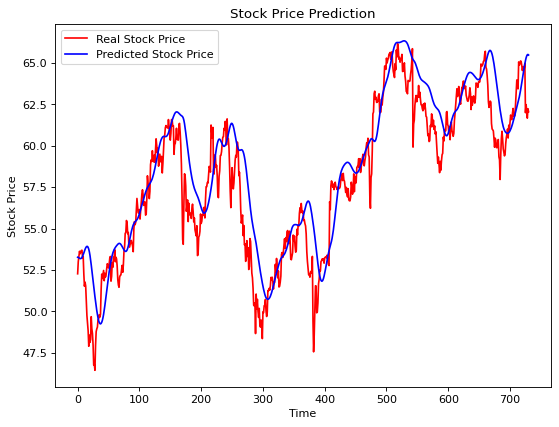

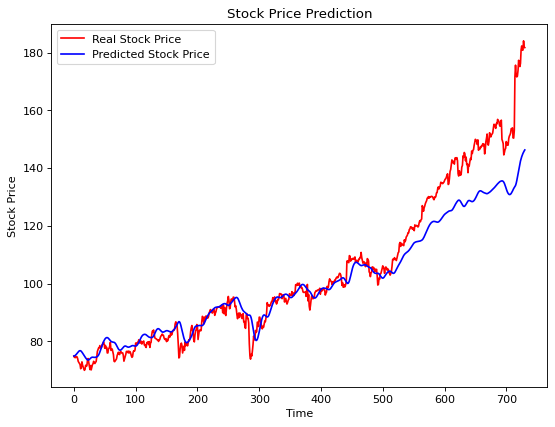

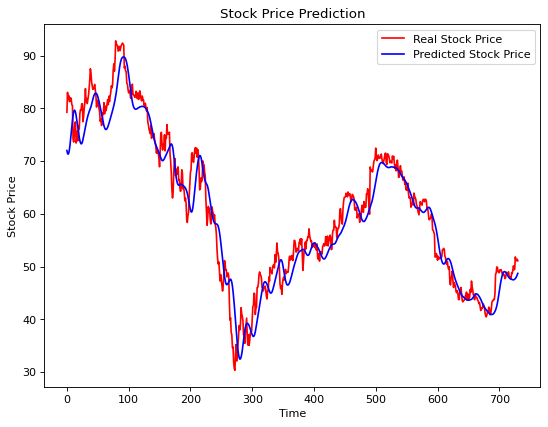

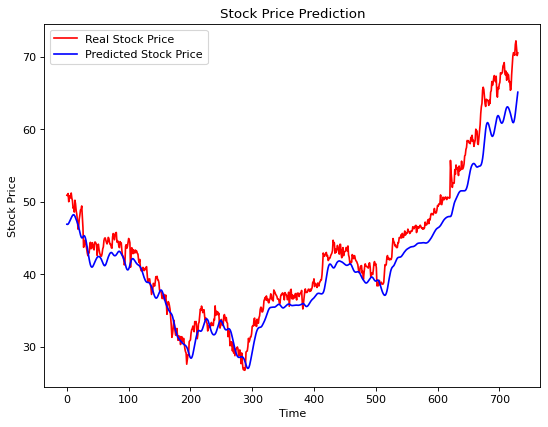

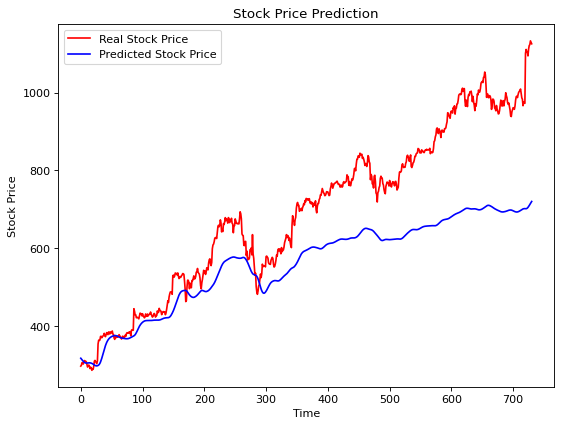

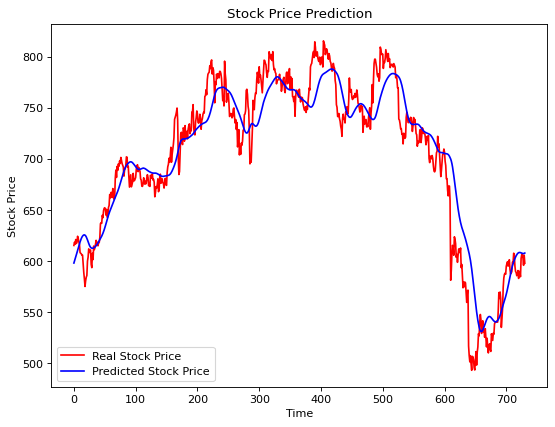

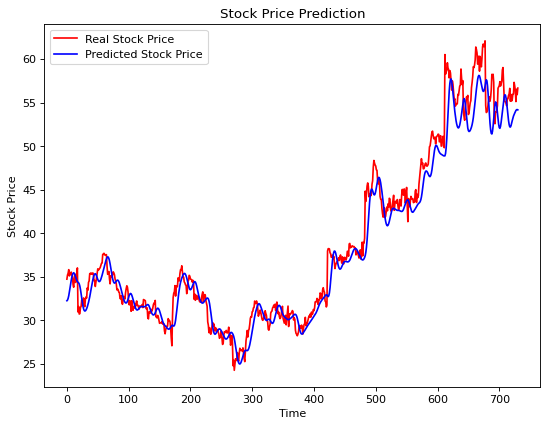

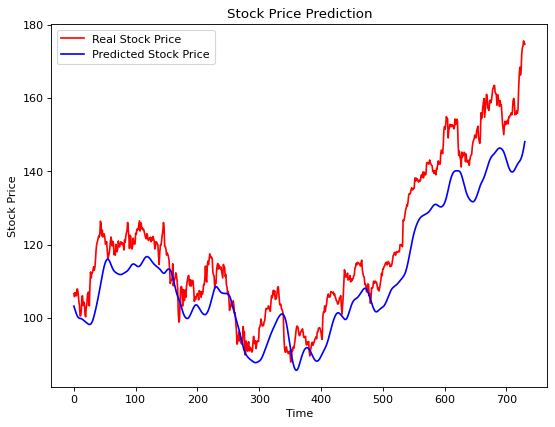

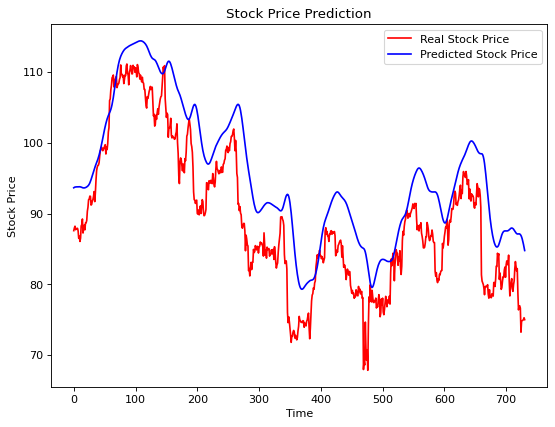

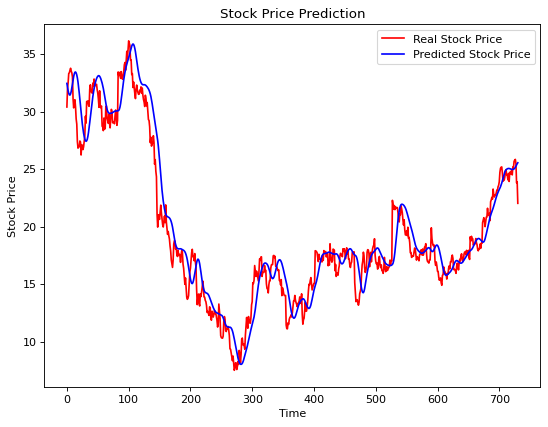

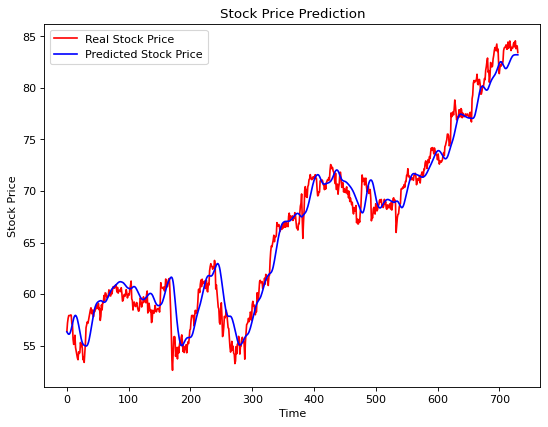

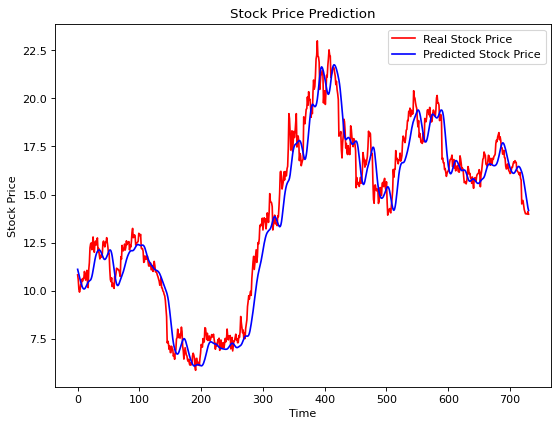

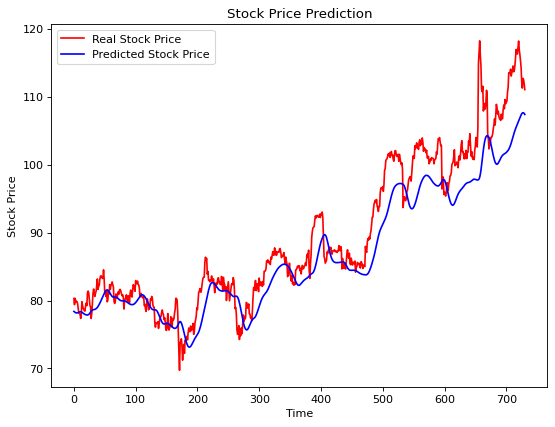

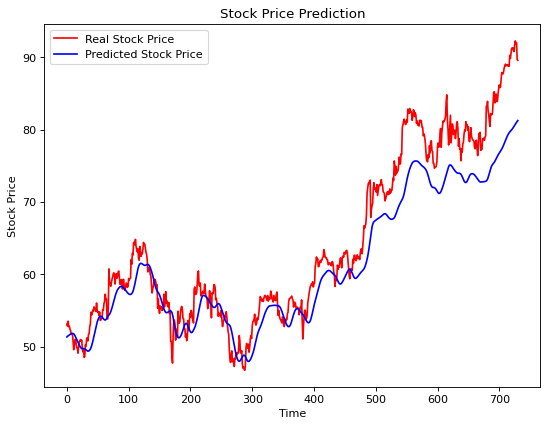

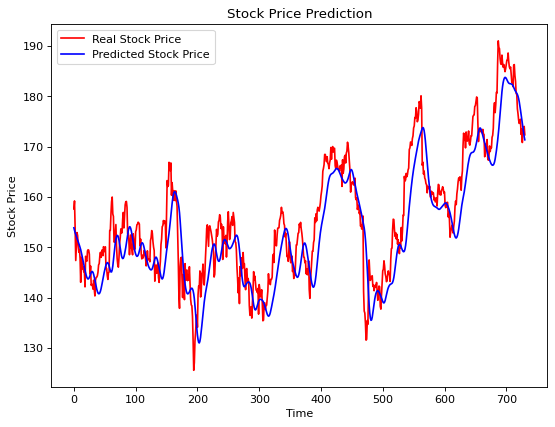

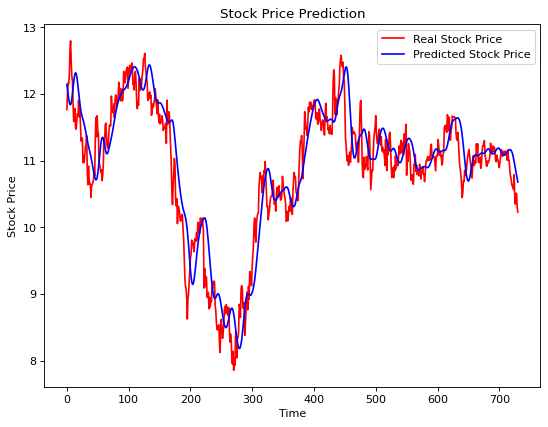

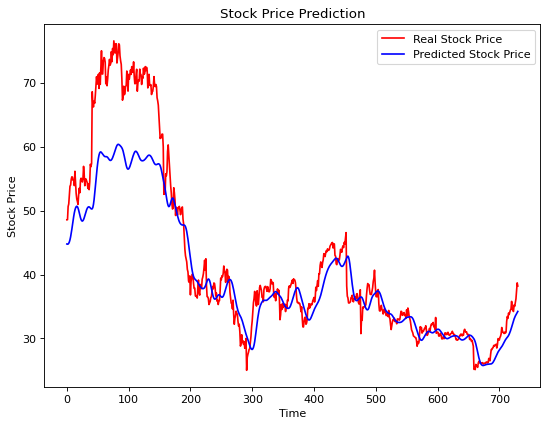

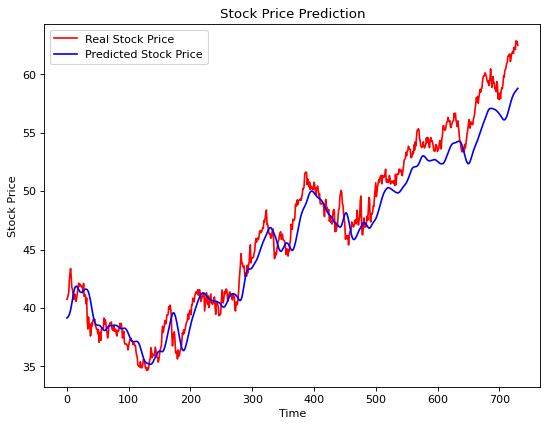

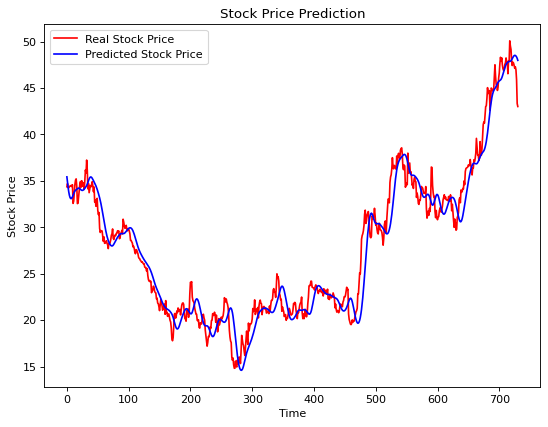

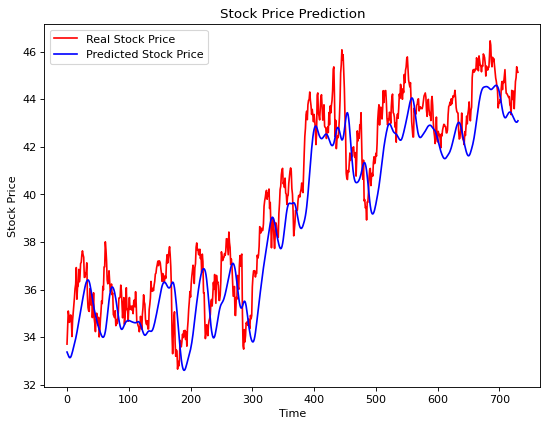

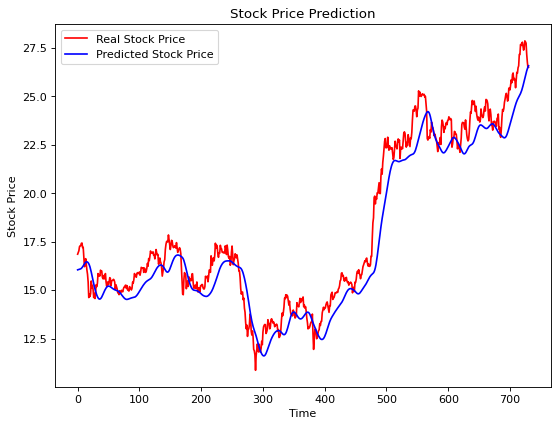

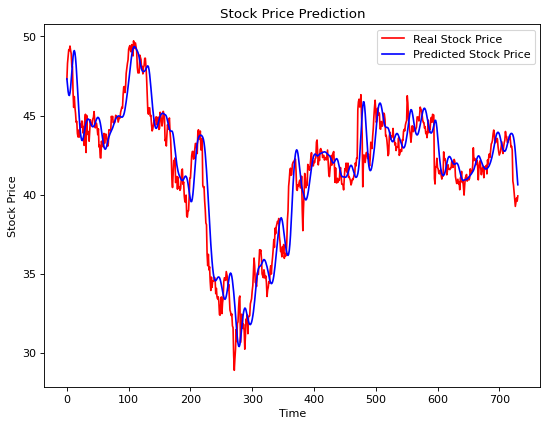

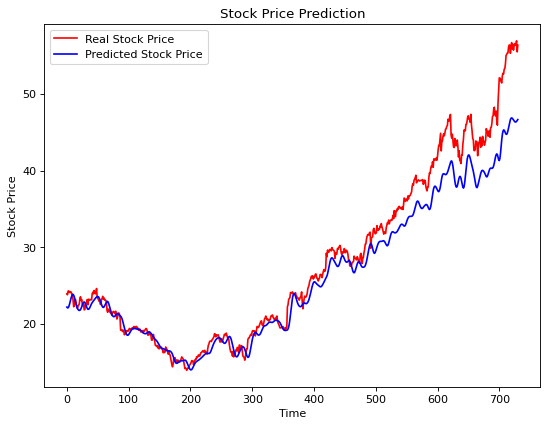

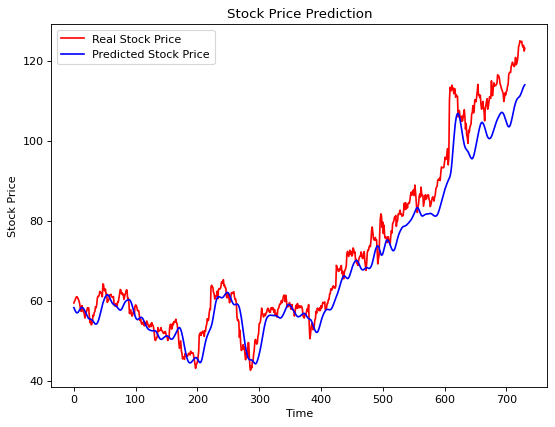

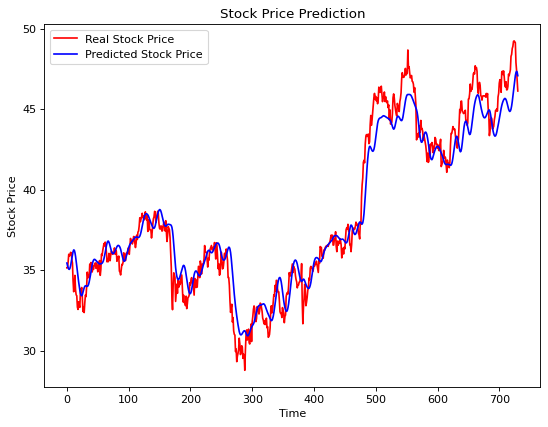

In [16]:
x = df[0].size-first_80_percent
for k, val in enumerate(forecast_each_timeseries):

    figure(figsize=(8, 6), dpi=80)
    dataset_test = df.iloc[first_80_percent:, val]

    plt.plot(range(0, x), dataset_test.values, color = 'red', label = 'Real Stock Price')
    plt.plot(range(0, x), predicted_stock_price[k], color = 'blue', label = 'Predicted Stock Price')
    plt.xticks(np.arange(0, 730, 100))
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()